In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import FinanceDataReader as fdr

df1 = pd.read_csv('tr_basic_cardl_20210101_20230630.csv') #롯데카드
df2 = pd.read_csv('tr_basic_cardh_20190101_20230630.csv') #하나카드
df3 = pd.read_csv('LIST_BT.csv') #종목코드

lottecard = df1[df1['mandata_brand_name'].isin(['HYUNDAI DEPARTMENT STORE CO LTD_ALL', 'SHINSEGAE INC_ALL'])]
hanacard = df2[df2['mandata_brand_name'].isin(['HYUNDAI DEPARTMENT STORE CO LTD_ALL', 'SHINSEGAE INC_ALL'])]
card_data = pd.merge(lottecard, hanacard, on=['transaction_date', 'mandata_brand_name'], how='outer')
card_data.to_csv('card_data_(hyundai,shinsegae).csv', index=False)

In [2]:
data = pd.read_csv('card_data_(hyundai,shinsegae).csv', parse_dates=['transaction_date'])
data['mon'] = data['transaction_date'].dt.month
data['year'] = data['transaction_date'].dt.year
monthly_data = data.groupby(['mandata_brand_name', 'year', 'mon']).agg({
    'sales_l': 'sum',
    'number_l': 'sum',
    'users_l': 'sum',
    'sales_h': 'sum',
    'number_h': 'sum',
    'users_h': 'sum'
}).reset_index()
yearly_data = data.groupby(['mandata_brand_name', 'year']).agg({
    'sales_l': 'sum',
    'number_l': 'sum',
    'users_l': 'sum',
    'sales_h': 'sum',
    'number_h': 'sum',
    'users_h': 'sum'
}).reset_index()
monthly_data['sales_all_month'] = monthly_data['sales_l'] + monthly_data['sales_h']
# monthly_data['sales_all_month'] = monthly_data['sales_h']
yearly_data['sales_all_year'] = yearly_data['sales_l'] + yearly_data['sales_h']
# yearly_data['sales_all_year'] = yearly_data['sales_h']
monthly_data = pd.merge(monthly_data, yearly_data[['mandata_brand_name', 'year', 'sales_all_year']], on=['mandata_brand_name', 'year'], how='left', suffixes=('', '_right'))

monthly_data.to_csv('sales_data_(hyundai,shinsegae).csv', index=False)

In [3]:
h_close = pd.read_csv('h_close.csv', parse_dates=['transaction_date'])
s_close = pd.read_csv('s_close.csv', parse_dates=['transaction_date'])
close_hs = pd.merge(h_close, s_close[['transaction_date', 'Close']], on='transaction_date', how='left', suffixes=('_h', '_s'))
close_hs.to_csv('stock_data_(hyundai,shinsegae).csv', index=False)

In [4]:
df = pd.read_csv('sales_data_(hyundai,shinsegae).csv')

#연매출비교
dfsaleyear = df.groupby(['year', 'mandata_brand_name'])['sales_all_year'].first().reset_index()
total_sales_by_year = dfsaleyear.groupby('year')['sales_all_year'].transform('sum')
dfsaleyear['yearly_ratio'] = dfsaleyear['sales_all_year'] / total_sales_by_year
yearly_ratio = dfsaleyear.copy()
yearly_ratio['year'] += 1

#월매출비교
dfsalemon = df.groupby(['year', 'mon', 'mandata_brand_name'])['sales_all_month'].sum().reset_index()
total_sales_by_mon_year = dfsalemon.groupby(['mon', 'year'])['sales_all_month'].sum()
dfsalemon['monthly_ratio'] = dfsalemon.apply(lambda row: row['sales_all_month'] / total_sales_by_mon_year.loc[(row['mon'], row['year'])], axis=1)
monthly_ratio = dfsalemon.copy()

for i in range(len(monthly_ratio)):
    year = monthly_ratio.loc[i, 'year']
    mon = monthly_ratio.loc[i, 'mon']
    name = monthly_ratio.loc[i, 'mandata_brand_name']
    
    yearly_ratio_value = yearly_ratio[(yearly_ratio['year'] == year) & (yearly_ratio['mandata_brand_name'] == name)]['yearly_ratio'].values
    monthly_ratio_value = monthly_ratio[(monthly_ratio['year'] == year) & (monthly_ratio['mon'] == mon) & (monthly_ratio['mandata_brand_name'] == name)]['monthly_ratio'].values

    if yearly_ratio_value.size > 0 and monthly_ratio_value.size > 0:
        if monthly_ratio_value[0] > yearly_ratio_value[0]:
            monthly_ratio.loc[i, 'active'] = 'buy'
        elif monthly_ratio_value[0] < yearly_ratio_value[0]:
            monthly_ratio.loc[i, 'active'] = 'sell'
        else:
            monthly_ratio.loc[i, 'active'] = 'hold'
    else:
        monthly_ratio.loc[i, 'active'] = 'no data'

monthly_ratio.to_csv('monthly_active_(hyundai,shinsegae).csv', index=False)

monthly_ratio = monthly_ratio[monthly_ratio['active'] != 'no data']
sell_previous = monthly_ratio[monthly_ratio['active'] == 'buy']
sell_current = monthly_ratio[monthly_ratio['active'] == 'sell']
merged = sell_current.merge(sell_previous, how='outer', indicator=True)
changed_rows = merged[merged['_merge'] == 'right_only']
changed_rows = changed_rows.drop(columns=['_merge'])

changed_rows.to_csv('table_(hyundai,shinsegae).csv', index=True)

In [5]:
close_hs = pd.read_csv('stock_data_(hyundai,shinsegae).csv', index_col='transaction_date', parse_dates=True)

start_date = '2020-01-31'
end_date = '2020-02-28'

sell_h = close_hs.loc[start_date:end_date].copy()  # 복사본 생성
sell_h.loc[:, 'close_h_return'] = sell_h['Close_h'].pct_change()
sell_h.loc[:, 'close_s_return'] = sell_h['Close_s'].pct_change()
sell_h.loc[:, 'close_h_return'] = sell_h['close_h_return'].ffill()
sell_h.loc[:, 'close_s_return'] = sell_h['close_s_return'].ffill()
sell_h.loc[:, 'cumulative_h_return'] = (1 + sell_h['close_h_return']).cumprod() - 1
sell_h.loc[:, 'cumulative_s_return'] = (1 + sell_h['close_s_return']).cumprod() - 1
sell_h.loc[:, 'h_return_sell'] = -sell_h['cumulative_h_return']

sell_h.loc[:, 'return'] = sell_h['cumulative_s_return'] + sell_h['h_return_sell']
sell_h.to_csv('close_hs1.csv', index=True)

print("신세계 롱 누적수익률:", sell_h['cumulative_s_return'].iloc[-1]*100)
print("현대백화점 숏 누적수익률:", sell_h['h_return_sell'].iloc[-1]*100)
return1 = sell_h['return'].iloc[-1]  # 매매 누적수익률
print("매매 누적수익률:", return1*100)

신세계 롱 누적수익률: -11.61048689138573
현대백화점 숏 누적수익률: 9.102564102564104
매매 누적수익률: -2.507922788821626


In [6]:
start_date = '2020-02-28'
end_date ='2021-01-29'

sell_s = close_hs.loc[start_date:end_date].copy()

sell_s.loc[:, 'close_h_return'] = sell_s['Close_h'].pct_change()
sell_s.loc[:, 'close_s_return'] = sell_s['Close_s'].pct_change()
sell_s.loc[:, 'close_h_return'] = sell_s['close_h_return'].ffill()
sell_s.loc[:, 'close_s_return'] = sell_s['close_s_return'].ffill()
sell_s.loc[:, 'cumulative_h_return'] = (1 + sell_s['close_h_return']).cumprod() - 1
sell_s.loc[:, 'cumulative_s_return'] = (1 + sell_s['close_s_return']).cumprod() - 1
sell_s.loc[:, 's_return_sell'] = -sell_s['cumulative_s_return']
sell_s.loc[:, 'return'] = sell_s['cumulative_h_return'] + sell_s['s_return_sell'] + return1
sell_s.to_csv('close_hs2.csv', index=True)

print("신세계 숏 누적수익률:", sell_s['s_return_sell'].iloc[-1]*100)
print("현대백화점 롱 누적수익률:", sell_s['cumulative_h_return'].iloc[-1]*100)
print("매매 누적수익률:", sell_s['return'].iloc[-1]*100)
return1 = sell_s['return'].iloc[-1]  # 매매 누적수익률

신세계 숏 누적수익률: 1.0593220338983134
현대백화점 롱 누적수익률: 10.296191819463951
매매 누적수익률: 8.847591064540639


In [7]:
start_date = end_date
end_date = '2021-03-31'

sell_h = close_hs.loc[start_date:end_date].copy()  # 복사본 생성
sell_h.loc[:, 'close_h_return'] = sell_h['Close_h'].pct_change()
sell_h.loc[:, 'close_s_return'] = sell_h['Close_s'].pct_change()
sell_h.loc[:, 'close_h_return'] = sell_h['close_h_return'].ffill()
sell_h.loc[:, 'close_s_return'] = sell_h['close_s_return'].ffill()
sell_h.loc[:, 'cumulative_h_return'] = (1 + sell_h['close_h_return']).cumprod() - 1
sell_h.loc[:, 'cumulative_s_return'] = (1 + sell_h['close_s_return']).cumprod() - 1
sell_h.loc[:, 'h_return_sell'] = -sell_h['cumulative_h_return']

sell_h.loc[:, 'return'] = sell_h['cumulative_s_return'] + sell_h['h_return_sell'] + return1
sell_h.to_csv('close_hs3.csv', index=True)

print("신세계 롱 누적수익률:", sell_h['cumulative_s_return'].iloc[-1]*100)
print("현대백화점 숏 누적수익률:", sell_h['h_return_sell'].iloc[-1]*100)
return1 = sell_h['return'].iloc[-1]  # 매매 누적수익률
print("매매 누적수익률:", return1*100)

신세계 롱 누적수익률: 20.342612419700213
현대백화점 숏 누적수익률: -15.984654731457892
매매 누적수익률: 13.205548752782958


In [8]:
start_date = end_date
end_date ='2021-08-31'

sell_s = close_hs.loc[start_date:end_date].copy()

sell_s.loc[:, 'close_h_return'] = sell_s['Close_h'].pct_change()
sell_s.loc[:, 'close_s_return'] = sell_s['Close_s'].pct_change()
sell_s.loc[:, 'close_h_return'] = sell_s['close_h_return'].ffill()
sell_s.loc[:, 'close_s_return'] = sell_s['close_s_return'].ffill()
sell_s.loc[:, 'cumulative_h_return'] = (1 + sell_s['close_h_return']).cumprod() - 1
sell_s.loc[:, 'cumulative_s_return'] = (1 + sell_s['close_s_return']).cumprod() - 1
sell_s.loc[:, 's_return_sell'] = -sell_s['cumulative_s_return']
sell_s.loc[:, 'return'] = sell_s['cumulative_h_return'] + sell_s['s_return_sell'] + return1
sell_s.to_csv('close_hs4.csv', index=True)

print("신세계 숏 누적수익률:", sell_s['s_return_sell'].iloc[-1]*100)
print("현대백화점 롱 누적수익률:", sell_s['cumulative_h_return'].iloc[-1]*100)
print("매매 누적수익률:", sell_s['return'].iloc[-1]*100)
return1 = sell_s['return'].iloc[-1]  # 매매 누적수익률

신세계 숏 누적수익률: 4.270462633451954
현대백화점 롱 누적수익률: -10.915104740903992
매매 누적수익률: 6.560906645330922


In [9]:
start_date = end_date
end_date = '2021-10-29'

sell_h = close_hs.loc[start_date:end_date].copy()  # 복사본 생성
sell_h.loc[:, 'close_h_return'] = sell_h['Close_h'].pct_change()
sell_h.loc[:, 'close_s_return'] = sell_h['Close_s'].pct_change()
sell_h.loc[:, 'close_h_return'] = sell_h['close_h_return'].ffill()
sell_h.loc[:, 'close_s_return'] = sell_h['close_s_return'].ffill()
sell_h.loc[:, 'cumulative_h_return'] = (1 + sell_h['close_h_return']).cumprod() - 1
sell_h.loc[:, 'cumulative_s_return'] = (1 + sell_h['close_s_return']).cumprod() - 1
sell_h.loc[:, 'h_return_sell'] = -sell_h['cumulative_h_return']

sell_h.loc[:, 'return'] = sell_h['cumulative_s_return'] + sell_h['h_return_sell'] + return1
sell_h.to_csv('close_hs5.csv', index=True)

print("신세계 롱 누적수익률:", sell_h['cumulative_s_return'].iloc[-1]*100)
print("현대백화점 숏 누적수익률:", sell_h['h_return_sell'].iloc[-1]*100)
return1 = sell_h['return'].iloc[-1]  # 매매 누적수익률
print("매매 누적수익률:", return1*100)

신세계 롱 누적수익률: -7.806691449814174
현대백화점 숏 누적수익률: -2.4752475247524997
매매 누적수익률: -3.7210323292357517


In [10]:
start_date = end_date
end_date ='2021-12-30'
sell_s = close_hs.loc[start_date:end_date].copy()

sell_s.loc[:, 'close_h_return'] = sell_s['Close_h'].pct_change()
sell_s.loc[:, 'close_s_return'] = sell_s['Close_s'].pct_change()
sell_s.loc[:, 'close_h_return'] = sell_s['close_h_return'].ffill()
sell_s.loc[:, 'close_s_return'] = sell_s['close_s_return'].ffill()
sell_s.loc[:, 'cumulative_h_return'] = (1 + sell_s['close_h_return']).cumprod() - 1
sell_s.loc[:, 'cumulative_s_return'] = (1 + sell_s['close_s_return']).cumprod() - 1
sell_s.loc[:, 's_return_sell'] = -sell_s['cumulative_s_return']
sell_s.loc[:, 'return'] = sell_s['cumulative_h_return'] + sell_s['s_return_sell'] + return1
sell_s.to_csv('close_hs6.csv', index=True)

print("신세계 숏 누적수익률:", sell_s['s_return_sell'].iloc[-1]*100)
print("현대백화점 롱 누적수익률:", sell_s['cumulative_h_return'].iloc[-1]*100)
print("매매 누적수익률:", sell_s['return'].iloc[-1]*100)
return1 = sell_s['return'].iloc[-1]  # 매매 누적수익률

신세계 숏 누적수익률: -2.419354838709742
현대백화점 롱 누적수익률: -9.299516908212603
매매 누적수익률: -15.439904076158095


In [11]:
start_date = end_date
end_date = '2023-02-28'

sell_h = close_hs.loc[start_date:end_date].copy()  # 복사본 생성
sell_h.loc[:, 'close_h_return'] = sell_h['Close_h'].pct_change()
sell_h.loc[:, 'close_s_return'] = sell_h['Close_s'].pct_change()
sell_h.loc[:, 'close_h_return'] = sell_h['close_h_return'].ffill()
sell_h.loc[:, 'close_s_return'] = sell_h['close_s_return'].ffill()
sell_h.loc[:, 'cumulative_h_return'] = (1 + sell_h['close_h_return']).cumprod() - 1
sell_h.loc[:, 'cumulative_s_return'] = (1 + sell_h['close_s_return']).cumprod() - 1
sell_h.loc[:, 'h_return_sell'] = -sell_h['cumulative_h_return']

sell_h.loc[:, 'return'] = sell_h['cumulative_s_return'] + sell_h['h_return_sell'] + return1
sell_h.to_csv('close_hs7.csv', index=True)

print("신세계 롱 누적수익률:", sell_h['cumulative_s_return'].iloc[-1]*100)
print("현대백화점 숏 누적수익률:", sell_h['h_return_sell'].iloc[-1]*100)
return1 = sell_h['return'].iloc[-1]  # 매매 누적수익률
print("매매 누적수익률:", return1*100)

신세계 롱 누적수익률: -19.685039370078538
현대백화점 숏 누적수익률: 27.696404793608576
매매 누적수익률: -7.428538652628058


In [12]:
start_date = end_date
end_date ='2023-04-28'
sell_s = close_hs.loc[start_date:end_date].copy()

sell_s.loc[:, 'close_h_return'] = sell_s['Close_h'].pct_change()
sell_s.loc[:, 'close_s_return'] = sell_s['Close_s'].pct_change()
sell_s.loc[:, 'close_h_return'] = sell_s['close_h_return'].ffill()
sell_s.loc[:, 'close_s_return'] = sell_s['close_s_return'].ffill()
sell_s.loc[:, 'cumulative_h_return'] = (1 + sell_s['close_h_return']).cumprod() - 1
sell_s.loc[:, 'cumulative_s_return'] = (1 + sell_s['close_s_return']).cumprod() - 1
sell_s.loc[:, 's_return_sell'] = -sell_s['cumulative_s_return']
sell_s.loc[:, 'return'] = sell_s['cumulative_h_return'] + sell_s['s_return_sell'] + return1
sell_s.to_csv('close_hs8.csv', index=True)

print("신세계 숏 누적수익률:", sell_s['s_return_sell'].iloc[-1]*100)
print("현대백화점 롱 누적수익률:", sell_s['cumulative_h_return'].iloc[-1]*100)
print("매매 누적수익률:", sell_s['return'].iloc[-1]*100)
return1 = sell_s['return'].iloc[-1]  # 매매 누적수익률

신세계 숏 누적수익률: -0.9803921568628082
현대백화점 롱 누적수익률: -4.788213627992666
매매 누적수익률: -13.197144437483532


In [13]:
start_date =end_date
end_date = '2023-06-30'

sell_h = close_hs.loc[start_date:end_date].copy()  # 복사본 생성
sell_h.loc[:, 'close_h_return'] = sell_h['Close_h'].pct_change()
sell_h.loc[:, 'close_s_return'] = sell_h['Close_s'].pct_change()
sell_h.loc[:, 'close_h_return'] = sell_h['close_h_return'].ffill()
sell_h.loc[:, 'close_s_return'] = sell_h['close_s_return'].ffill()
sell_h.loc[:, 'cumulative_h_return'] = (1 + sell_h['close_h_return']).cumprod() - 1
sell_h.loc[:, 'cumulative_s_return'] = (1 + sell_h['close_s_return']).cumprod() - 1
sell_h.loc[:, 'h_return_sell'] = -sell_h['cumulative_h_return']

sell_h.loc[:, 'return'] = sell_h['cumulative_s_return'] + sell_h['h_return_sell'] + return1
sell_h.to_csv('close_hs9.csv', index=True)

print("신세계 롱 누적수익률:", sell_h['cumulative_s_return'].iloc[-1]*100)
print("현대백화점 숏 누적수익률:", sell_h['h_return_sell'].iloc[-1]*100)
return1 = sell_h['return'].iloc[-1]  # 매매 누적수익률
print("매매 누적수익률:", return1*100)

신세계 롱 누적수익률: -13.543689320388374
현대백화점 숏 누적수익률: 4.642166344294019
매매 누적수익률: -22.09866741357789


In [14]:
start_date = end_date
end_date ='2023-07-31'
sell_s = close_hs.loc[start_date:end_date].copy()

sell_s.loc[:, 'close_h_return'] = sell_s['Close_h'].pct_change()
sell_s.loc[:, 'close_s_return'] = sell_s['Close_s'].pct_change()
sell_s.loc[:, 'close_h_return'] = sell_s['close_h_return'].ffill()
sell_s.loc[:, 'close_s_return'] = sell_s['close_s_return'].ffill()
sell_s.loc[:, 'cumulative_h_return'] = (1 + sell_s['close_h_return']).cumprod() - 1
sell_s.loc[:, 'cumulative_s_return'] = (1 + sell_s['close_s_return']).cumprod() - 1
sell_s.loc[:, 's_return_sell'] = -sell_s['cumulative_s_return']
sell_s.loc[:, 'return'] = sell_s['cumulative_h_return'] + sell_s['s_return_sell'] + return1
sell_s.to_csv('close_hs10.csv', index=True)

print("신세계 숏 누적수익률:", sell_s['s_return_sell'].iloc[-1]*100)
print("현대백화점 롱 누적수익률:", sell_s['cumulative_h_return'].iloc[-1]*100)
print("매매 누적수익률:", sell_s['return'].iloc[-1]*100)
return1 = sell_s['return'].iloc[-1]  # 매매 누적수익률

신세계 숏 누적수익률: -7.355418304323358
현대백화점 롱 누적수익률: 12.37322515212982
매매 누적수익률: -17.080860565771427


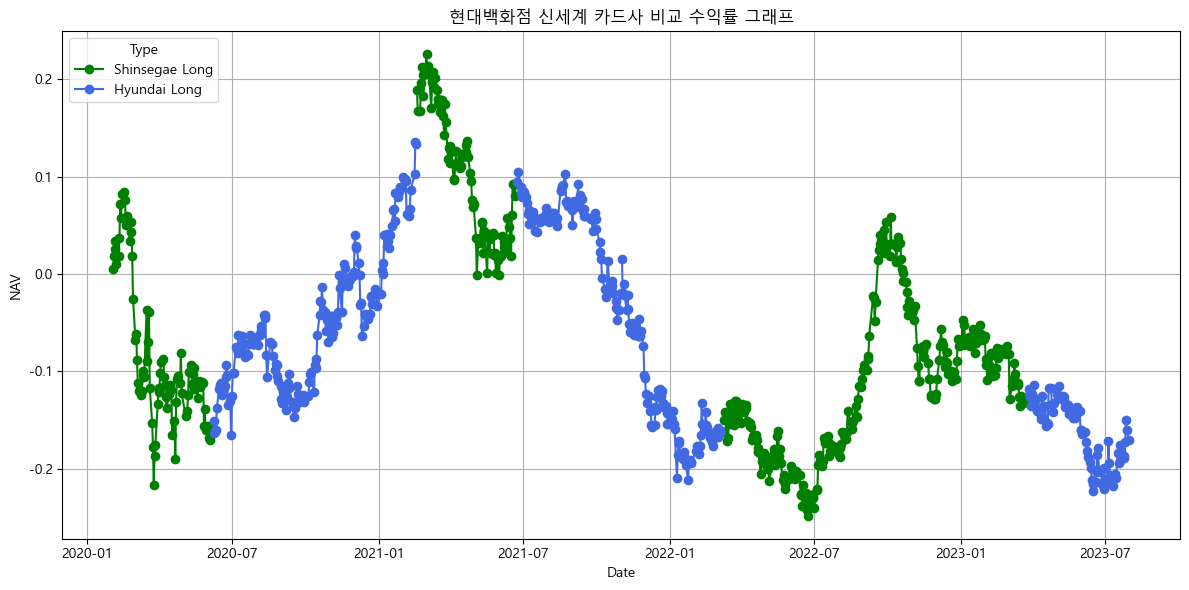

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

plt.rc('font', family='Malgun Gothic') # 폰트 지정
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정

# 빈 데이터프레임 생성
combined_df = pd.DataFrame()

# 파일을 하나씩 읽어와서 데이터프레임에 추가
for i in range(1, 11):
    file_name = f"close_hs{i}.csv"
    df = pd.read_csv(file_name, parse_dates=['transaction_date'])
    df['type'] = 'Shinsegae Long' if i % 2 == 1 else 'Hyundai Long'  # 홀수는 롯데 롱, 짝수는 현대 롱
    combined_df = pd.concat([combined_df, df])

# 필요한 전처리 수행
combined_df.dropna(subset=['return'], inplace=True)

# 파일을 구간별로 나누어 그래프 그리기
plt.figure(figsize=(12, 6))
start_index = 0
colors = {'Hyundai Long': 'royalblue', 'Shinsegae Long': 'green'}  # 각 타입에 대한 색상 지정
for i in range(1, 11):
    end_index = i * len(combined_df) // 10
    segment_df = combined_df.iloc[start_index:end_index]
    type_name = segment_df['type'].iloc[0]  # 현재 구간의 타입 가져오기
    marker = 'o'  # marker를 설정하여 모든 그룹에 대해 점으로 표시
    plt.plot(segment_df['transaction_date'], segment_df['return'], label=f'Segment {i}', color=colors[type_name], marker=marker)
    start_index = end_index

# 범주 추가
plt.legend(title='Type', loc='upper left', labels=list(reversed(sorted(colors.keys()))))  # 롯데 롱이 먼저 표시되도록 범주를 역순으로 정렬하여 표시

plt.xlabel('Date')
plt.ylabel('NAV')
plt.title('현대백화점 신세계 카드사 비교 수익률 그래프')
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'

참고들

In [ ]:
close_dm = pd.read_csv('card_data_(daesung,mega).csv', parse_dates=['transaction_date'])
close_dm = close_dm[['transaction_date', 'mandata_brand_name']]
m_df = close_dm[close_dm['mandata_brand_name'] == 'MEGASTUDYCO LTD_ALL']
d_df = close_dm[close_dm['mandata_brand_name'] == 'DIGITAL DAESUNG CO LTD_ALL']

m_df = m_df.sort_values(by='transaction_date')
d_df = d_df.sort_values(by='transaction_date')

next_month_date = m_df['transaction_date'].iloc[-1] + pd.offsets.MonthBegin(1)

new_data = {
    'transaction_date': pd.date_range(start=next_month_date, periods=31),
    'mandata_brand_name': ['MEGASTUDYCO LTD_ALL'] * 31
}
new_data2 = {
    'transaction_date': pd.date_range(start=next_month_date, periods=31),
    'mandata_brand_name': ['DIGITAL DAESUNG CO LTD_ALL'] * 31
}

new_rows_df = pd.DataFrame(new_data)
new_rows_df2 = pd.DataFrame(new_data2)
m_df = pd.concat([m_df, new_rows_df], ignore_index=True)
d_df = pd.concat([d_df, new_rows_df2], ignore_index=True)

In [ ]:
m_close = fdr.DataReader('072870', '2021-02-01', '2023-07-31') 
m_close = m_close[['Close']]
d_close = fdr.DataReader('068930', '2021-02-01', '2023-07-31') 
d_close = d_close[['Close']]
m_close.to_csv('m_close.csv', index=True)
d_close.to_csv('d_close.csv', index=True)

h_close = fdr.DataReader('069960', '2019-01-31', '2023-07-31') 
h_close = h_close[['Close']]
l_close = fdr.DataReader('023530', '2019-01-31', '2023-07-31') 
l_close = l_close[['Close']]
h_close.to_csv('h_close.csv', index=True)
l_close.to_csv('l_close.csv', index=True)

e_close = fdr.DataReader('139480', '2019-01-31', '2023-07-31') 
e_close = e_close[['Close']]
s_close = fdr.DataReader('004170', '2019-01-31', '2023-07-31') 
s_close = s_close[['Close']]
e_close.to_csv('e_close.csv', index=True)
s_close.to_csv('s_close.csv', index=True)